# EMNIST Letter detection 

Dataset: EMNIST. It contains handwritten **letters** instead of digits. The data is messier and more varied, and there are 26 classes instead of 10, so the model will need to work a little harder to get things right.

<a name='imports'></a>
## Imports

In [1]:
import os 
import torch
from torchvision import transforms, datasets
import torchvision.transforms.functional as f
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim as optim

In [31]:
import helper_utils

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device: {DEVICE}")    

using device: cuda


<a name='1'></a>
## 1 - Letter Images

We'll start by loading the EMNIST dataset, focusing on the **Letters** subset.
It extends MNIST by providing handwritten **letters** instead of digits.
This subset includes **124,800 grayscale images** for training and **20,800 images** for testing, each labeled with one of **26 lowercase letter classes**.

<a name='1.1'></a>
### 1.1 - Load the Dataset

Before we can work with the EMNIST Letters data, we'll need to make sure it’s available in the workspace.
If it’s not already there, download it using `torchvision.datasets.EMNIST`.
we’ll be using the `letters` split of the EMNIST dataset, which includes handwritten characters from 'a' through 'z'.
To select this subset, make sure to pass `split='letters'` to the `EMNIST` constructor.

In [4]:
data_path = './EMNIST_data'

if os.path.exists(data_path) and os.path.isdir(data_path):
	download = False
	print("Data folder found locally. Loading data from folder")
	
else:
	download = True
	print("Data not found locally. Downloading data...")

train_dataset = datasets.EMNIST(
	root = data_path,
	split = 'letters',
	train = True,
	download = download
)

test_dataset = datasets.EMNIST(
	root = data_path,
	split = 'letters',
	train = False,
	download = download
)


Data folder found locally. Loading data from folder


<a name='1.2'></a>
### 1.2 - Explore the Raw Data

Now that the dataset is loaded, we'll take a moment to see what we’re working with. Visualizing a few samples will help understand how the letters are written and what challenges the model might face.



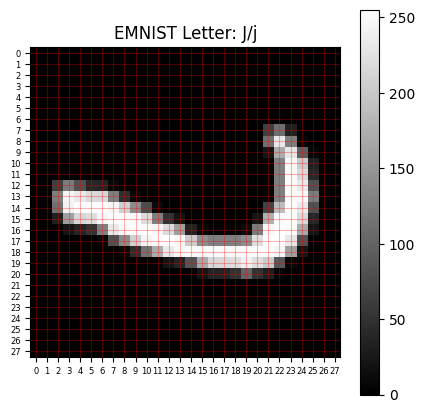

In [5]:
index = 900

img, label = train_dataset[index]

helper_utils.visualize_image(img, label)

Notice that the handwritten letters appear rotated or flipped. Technically, a model can still learn from them as long as **every image is oriented the same way**. The model doesn’t “know” what properly oriented letter looks like; it just learns patterns that are consistent across the dataset.

However, this can make it harder for *us* to visually inspect or interpret the samples.
In the next step, we’ll use a helper function to display the letters in a more familiar orientation so they’re easier to look at. This correction is only for visualization. The underlying data will remain unchanged, and the model will still train on it exactly as provided.

### 1.3 Pre-processing the Images
We will apply transforms to the images before we convert to Pytorch object. 
To do this, we can use `transforms.Compose` to apply sequence of pre-processing
* `transforms.ToTensor()`  - Convert image to tensor
*  `transforms.Normalize(mean, std)` - scales pixel value with pre-computed mean and std

In [6]:

def compute_mean_std(data_path, download):

    temp_transform = transforms.ToTensor()

    train_temp = datasets.EMNIST(
        root=data_path,
        split="balanced",   # keep this fixed
        train=True,
        download=download,
        transform=temp_transform
    )

    #To compute image stats, we need a temporary data loader.
    temp_loader = DataLoader(train_temp, batch_size=32, shuffle=False)

    # we need to compute mean and std to apply normalization on images
    mean = 0.0
    std = 0.0
    total_pixels= 0
    
    for images,_ in temp_loader:
        total_pixels += images.numel()        
        mean += images.sum()
        std += (images**2).sum()
    
    mean /= total_pixels
    std = torch.sqrt(std / total_pixels - mean **2)
    return mean, std

In [7]:
mean, std = compute_mean_std(data_path, download)
print(f"mean: {mean}\n std: {std}")

mean: 0.1751042753458023
 std: 0.33323758840560913


In [8]:
#create the transforms

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean = mean, std= std)
])

train_dataset.transform = transform
test_dataset.transform = transform

In [9]:
img_tensor, label = train_dataset[90000]
print(img_tensor)

tensor([[[-0.5255, -0.5255, -0.5255, -0.5255, -0.5255, -0.5255, -0.5255,
          -0.5255, -0.5255, -0.5255, -0.5255, -0.5255, -0.5255, -0.5255,
          -0.5255, -0.5255, -0.5255, -0.5255, -0.5255, -0.5255, -0.5255,
          -0.5255, -0.5255, -0.5255, -0.5255, -0.5255, -0.5255, -0.5255],
         [-0.5255, -0.5255, -0.5255, -0.5255, -0.5255, -0.5255, -0.5255,
          -0.5255, -0.5255, -0.5255, -0.5255, -0.5255, -0.5255, -0.5255,
          -0.5255, -0.5255, -0.5255, -0.5255, -0.5255, -0.5255, -0.5255,
          -0.4784, -0.4313, -0.4313, -0.5255, -0.5255, -0.5255, -0.5255],
         [-0.5255, -0.5255, -0.5255, -0.5255, -0.5255, -0.5255, -0.5255,
          -0.5255, -0.5255, -0.5255, -0.5255, -0.5255, -0.5255, -0.5255,
          -0.5255, -0.5255, -0.5255, -0.5255, -0.5255, -0.4902,  0.0276,
           1.8517,  2.0753,  2.0282, -0.1489, -0.5255, -0.5255, -0.5255],
         [-0.5255, -0.5255, -0.5255, -0.5255, -0.5255, -0.5255, -0.5255,
          -0.5255, -0.5255, -0.5255, -0.5255, -0

Npw we have a scaled tensors centered around 0 and std 1. Also the image dataset has rotated and flipped images which needs to corrected. `correct_image_orientation` function will take of it. 

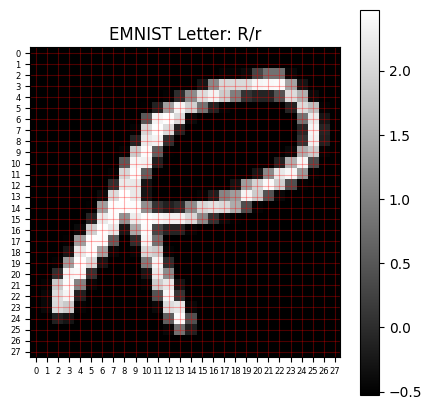

In [10]:
def correct_image_orientation(image):
    rotated = f.rotate(image, 90)
    flipped = f.vflip(rotated)

    return flipped

img_transformed = correct_image_orientation(img_tensor)

helper_utils.visualize_image(img_transformed, label) 

<a name='1.4'></a>
### 1.4 - Loading Data in Batches

The neural network needs input in a structured, consistent format. To achieve that, we’ll use PyTorch’s `DataLoader` to organize the preprocessed letter images into batches—making training more efficient and easier to manage.

These loaders will automatically handle batching and shuffling, ensuring that your model trains effectively and generalizes well.

In [11]:
def dataloaders(train_dataset, test_dataset, batch_size=32):
    """ Creates Dataloader objects for EMNIST training and test dataset 
    """
    train_loader = DataLoader(
                    dataset= train_dataset,
                    batch_size= batch_size,
                    shuffle=True
    )

    test_loader = DataLoader(
                    dataset= test_dataset,
                    batch_size= batch_size,
                    shuffle=False
    )

    return train_loader, test_loader


In [12]:
train_loader, test_loader = dataloaders(train_dataset, test_dataset)
print("--- Train Loader --- \n")
print(f"Total Images:{len(train_loader.dataset)}")
print(f"Total Batches:{len(train_loader)}")
print(f"Batch Size:{train_loader.batch_size}")
print(f"Image Shape:{train_loader.dataset.data.shape}")
print(f"Label Shape:{len(train_loader.dataset.targets.shape)}")
print("\n--- Test Loader --- \n")
print(f"Total Images:{len(test_loader.dataset)}")
print(f"Total Batches:{len(test_loader)}")
print(f"Batch Size:{test_loader.batch_size}")
print(f"Image Shape:{test_loader.dataset.data.shape}")
print(f"Label Shape:{test_loader.dataset.targets.shape}")


--- Train Loader --- 

Total Images:124800
Total Batches:3900
Batch Size:32
Image Shape:torch.Size([124800, 28, 28])
Label Shape:1

--- Test Loader --- 

Total Images:20800
Total Batches:650
Batch Size:32
Image Shape:torch.Size([20800, 28, 28])
Label Shape:torch.Size([20800])


In [13]:
train_loader.dataset.targets.shape

torch.Size([124800])

### 2 - Model Building
Now we will create the EMNIST model function that creates the PyTorch Sequential model for classification
<br>
- Architecture:
> * Flatten Layer - To flatten the image so it can connect with the layers
> * Linear Layer - 784 units
> * ReLU Layer 
> * Linear Layer - 256 units
> * ReLU layer
> * Linear Layer - num_classes units (26)



In [14]:
def model_builder(num_classes):
    """ Initializes the NN model for classification task
    """
    torch.manual_seed(42)

    model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,num_classes)
    )

    loss_function = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(),lr = 0.001)

    return model, loss_function, optimizer


In [15]:
model, loss_function, optimizer = model_builder(num_classes = 26)

### 3 - Training and Evaluation of Model

* **Within the epoch training loop**:
    * Zero the gradients of the optimizer.
    * Fill `outputs` with the model's predictions for the current `inputs`.
    * Calculate the `loss` using the `loss_function` with `outputs` and `targets`.
    * Perform backpropagation with `loss.backward()` and update the model parameters using the `optimizer`.

  * **For the calculation of loss and accuracy**:
    * Obtain the current `loss_value` using `loss.item()` and accumulate it in `running_loss`.
    * Obtain the `predicted_indices` by taking the `argmax` along dimension 1 of the `outputs`.
    * Obtain the `correct_predictions` by comparing `predicted_indices` to `targets`.
    * Get `num_correct_in_batch` by summing the correct predictions in the batch from `correct_predictions`.
    * Update `num_correct_predictions` by adding `num_correct_in_batch`.
    * Get the batch_size from the targets by using `targets.size(0)`.
    * Add the current batch size to `total_predictions`.

* **After all batches:**
  * Calculate the average loss for the epoch by dividing `running_loss` by the number of batches.
  * Calculate the accuracy percentage for the epoch.

In [16]:
def train(model, loss_function, optimizer, train_loader, device, verbose = True):
    """ This function runs the train function on the model for one epoch
    """

    model.train()

    running_loss = 0.0
    num_correct_predictions = 0
    total_predictions = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets - 1  # adjusting for EMNIST letter dataset label index
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        running_loss += loss_val

        predicted_indices = torch.argmax(outputs,1)
        correct_predictions = predicted_indices.eq(targets).sum().item()
        num_correct_in_batch = correct_predictions
        num_correct_predictions += num_correct_in_batch

        batch_size = targets.size(0)
        total_predictions+=batch_size

    average_loss = running_loss / len(train_loader)

    accuracy = num_correct_predictions / total_predictions *100

    if verbose:
        print(f"Epoch Loss (Avg): {average_loss:.3f} | Epoch Acc: {accuracy:.2f}")


    return model, average_loss


### 3.2 Evaluation of Model

* Disable gradient calculation using `torch.no_grad()` during evaluation.

* **For the loop over the batches in `test_loader`**:
    * Fill `outputs` with the model's predictions for the current `inputs`.
    * Obtain the `predicted_indices` by taking the `argmax` along dimension 1 of the `outputs`.
    * Obtain the `correct_predictions` by comparing `predicted_indices` to `targets`.
    * Get `num_correct_in_batch` by summing the correct predictions in the batch from `correct_predictions`.
    * Update `num_correct_predictions` by adding `num_correct_in_batch`.
    * Get the batch_size from the targets by using `targets.size(0)`.
    * Add the current batch size to `total_predictions`.

In [17]:
def evaluation(model, test_loader, device, verbose = True):
    """ Evaluates the model on the test dataset and returns the accuracy  
    """

    model.eval()

    num_correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():

        for inputs,targets in test_loader:
            inputs, targets =  inputs.to(device) , targets.to(device)
            outputs = model(inputs)
            predicted_indices = torch.argmax(outputs,1)
            correct_predictions = predicted_indices.eq(targets).sum().item()
            num_correct_in_batch = correct_predictions
            num_correct_predictions += num_correct_in_batch

            batch_size = targets.size(0)
            total_predictions +=batch_size

        accuracy = num_correct_predictions/total_predictions*100

        if verbose:
            print(f"Test Accuracy: {accuracy:.2f}%")

    return accuracy


### 3.3 - Putting it all together

Now that we have implemented both the training and evaluation functions, let's put everything together.
In this step, we'll use the previously defined `train` and `evaluate` functions to create a complete training and evaluation loop.


In [23]:
def train_and_evaluate(
    model, train_loader, test_loader, num_epochs, loss_function, optimizer, device):

    """ train and evaluation orchestration for the model
    """
    model = model.to(device)
    for epoch in range(num_epochs):
        print(f"Epoch: {epoch+1}")
        trained_model,_ = train(model, loss_function, optimizer, train_loader, device)

        accuracy = evaluation(model,test_loader, device)

    return trained_model

#### Train the Model

That is it! we have successfully implemented the training and evaluation functions for the model. It is now time to train the model on the EMNIST dataset and evaluate its performance.

In [19]:
# Set the number of training epochs. Don't set more than 15
num_epochs = 15

In [24]:

if num_epochs > 15 or num_epochs < 1:
    print(f"\033[91mSet num_epochs between 1 and 15 (inclusive).")

else:
    # Initialize the EMNIST model, loss function, and optimizer
    emnist_model, loss_function, optimizer = model_builder(num_classes=26)
    
    # Train and evaluate the model for the specified number of epochs
    trained_model = train_and_evaluate(
        model=emnist_model,
        train_loader=train_loader,
        test_loader=test_loader,
        num_epochs=num_epochs,
        loss_function=loss_function,
        optimizer=optimizer,
        device=DEVICE
    )

Epoch: 1
Epoch Loss (Avg): 0.570 | Epoch Acc: 82.18
Test Accuracy: 0.46%
Epoch: 2
Epoch Loss (Avg): 0.332 | Epoch Acc: 89.19
Test Accuracy: 0.38%
Epoch: 3
Epoch Loss (Avg): 0.281 | Epoch Acc: 90.63
Test Accuracy: 0.39%
Epoch: 4
Epoch Loss (Avg): 0.252 | Epoch Acc: 91.44
Test Accuracy: 0.38%
Epoch: 5
Epoch Loss (Avg): 0.229 | Epoch Acc: 92.12
Test Accuracy: 0.60%
Epoch: 6
Epoch Loss (Avg): 0.212 | Epoch Acc: 92.51
Test Accuracy: 0.58%
Epoch: 7
Epoch Loss (Avg): 0.199 | Epoch Acc: 93.02
Test Accuracy: 0.48%
Epoch: 8
Epoch Loss (Avg): 0.189 | Epoch Acc: 93.31
Test Accuracy: 0.55%
Epoch: 9
Epoch Loss (Avg): 0.180 | Epoch Acc: 93.61
Test Accuracy: 0.38%
Epoch: 10
Epoch Loss (Avg): 0.170 | Epoch Acc: 93.91
Test Accuracy: 0.45%
Epoch: 11
Epoch Loss (Avg): 0.165 | Epoch Acc: 94.01
Test Accuracy: 0.43%
Epoch: 12
Epoch Loss (Avg): 0.158 | Epoch Acc: 94.23
Test Accuracy: 0.50%
Epoch: 13
Epoch Loss (Avg): 0.154 | Epoch Acc: 94.38
Test Accuracy: 0.47%
Epoch: 14
Epoch Loss (Avg): 0.149 | Epoch Acc: 

In [25]:
# Evaluate the trained model's performance on each letter class
class_accuracies = helper_utils.evaluate_per_class(trained_model, test_loader, DEVICE)

# Print the accuracy for each letter class
for letter, accuracy in class_accuracies.items():
    print(f"Accuracy for {letter}: {(accuracy*100):.2f} %")

Accuracy for A: 88.38 %
Accuracy for B: 92.25 %
Accuracy for C: 94.50 %
Accuracy for D: 93.38 %
Accuracy for E: 93.50 %
Accuracy for F: 92.25 %
Accuracy for G: 79.62 %
Accuracy for H: 91.25 %
Accuracy for I: 82.75 %
Accuracy for J: 92.88 %
Accuracy for K: 91.00 %
Accuracy for L: 62.25 %
Accuracy for M: 97.12 %
Accuracy for N: 91.62 %
Accuracy for O: 95.12 %
Accuracy for P: 95.62 %
Accuracy for Q: 78.12 %
Accuracy for R: 92.38 %
Accuracy for S: 94.25 %
Accuracy for T: 93.12 %
Accuracy for U: 90.62 %
Accuracy for V: 90.88 %
Accuracy for W: 97.00 %
Accuracy for X: 93.75 %
Accuracy for Y: 90.88 %
Accuracy for Z: 96.25 %


In [ ]:
### save the trained model
helper_utils.save_model(model=trained_model, filename='trained_model_001.pth')

Model saved to trained_model_001.pth
